# Exp4: 基于K-近邻的车牌号识别

## 一、案例简介

图像的智能处理一直是人工智能领域广受关注的一类技术，代表性的如人脸识别与 CT 肿瘤识别，在人工智能落地的进程中发挥着重要作用。其中车牌号识别作为一个早期应用场景，已经融入日常生活中，为我们提供了诸多便利，在各地的停车场和出入口都能看到它的身影。车牌号识别往往分为字符划分和字符识别两个子任务，本案例我们将关注字符识别的任务，尝试用 K-NN 的方法对分割好的字符图像进行自动识别和转化。

## 二、作业说明

### 基本要求
* 完成数据的读入和表示，将图片表示成向量并和 label 对应上；
* 构建 K-NN 模型（可调库）对测试集中的图片进行预测并计算准确率；
* 分析当 K 取不同值时测试准确率的变化。

### 扩展要求
* 分析不同距离度量方式对模型效果的影响；
* 对比平权和加权 K-NN 的效果；
* 分析训练集大小对测试结果的影响。

In [12]:
import os
import random
import math
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split


## 三、数据概览
本次我们使用已经分割好的车牌图片作为数据集，包括数字 0-9、字母 A-Z（不包含 O 和 I）以及省份简称共 65 个类，编号从 0 到 64。数据已经分成了训练集和测试集，里面的文件夹用 label 编号命名，一个文件夹下的所有图片都属于该文件夹对应的类，每个图片都是 20 * 20 的二值化灰度图。

下面演示一下如何借助 PIL 库将图片转化为向量：

In [2]:
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
pixels = np.array(img)  # 转化为 numpy 矩阵
pixels.shape

img  # 显示图片

读取数据集。分为train和test两部分。

In [2]:
def load_data(path):
    img = []
    label = []

    data_labels = os.listdir(path)
    data_labels.pop(0)

    for i in range(len(data_labels)):
        data_dir = path+'/'+data_labels[i]
        datas = os.listdir(data_dir)
        for data in datas:
            tmp = Image.open(data_dir+'/'+data)
            img.append(np.array(tmp).flatten())
            label.append(int(data_labels[i]))

    return np.array(img),np.array(label)


train_X, train_y = load_data(path='./data/train')
test_X, test_y = load_data(path='./data/test')

assert len(train_X) == len(train_y) and len(test_X) == len(test_y)


数据集可视化，通过指定下标和维数，画灰度图

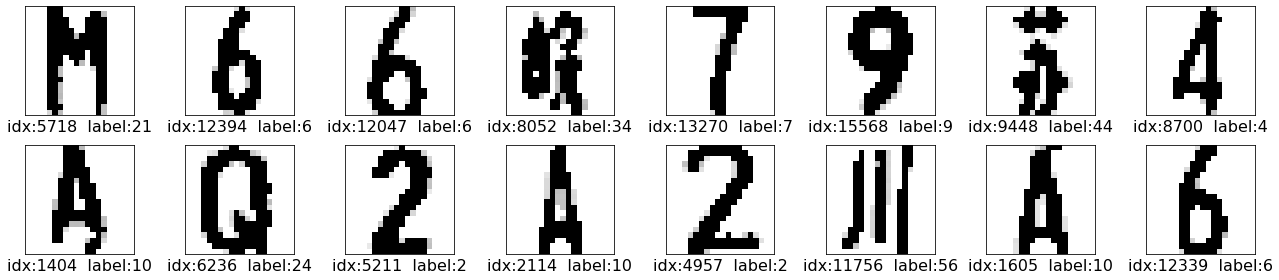

In [10]:
def draw(imgs, labels, pic_index, dim):
    rows, cols = math.ceil(len(pic_index)/8), 8
    fig, ax = plt.subplots(
        nrows=rows,
        ncols=cols,
        sharex=True,
        sharey=True, figsize=(18, 2*rows))

    ax = ax.flatten()
    for i in range(len(pic_index)):
        img = imgs[pic_index[i]].reshape(dim, dim)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i].set_xlabel("idx:"+str(pic_index[i])+"  label:" +
                         str(labels[pic_index[i]]), size=16)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()


draw(train_X, train_y, np.random.randint(0, len(train_X), size=(16)), 20)


## 四、模型构建

特征提取：一方面将不清晰的笔画加重，另一方面把噪点去除。

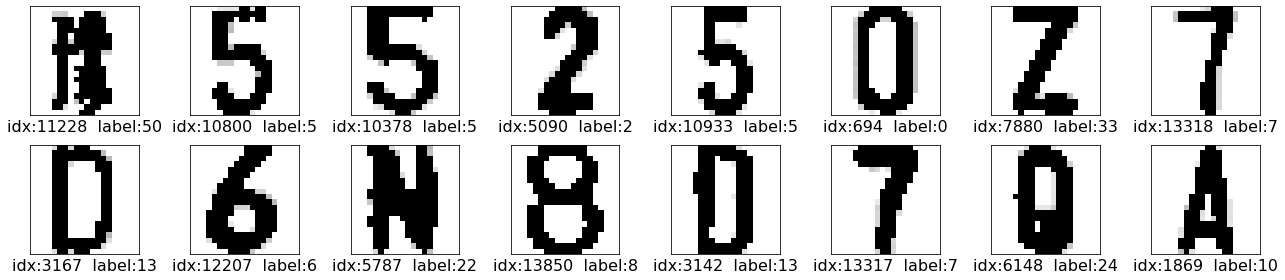

In [11]:
max_thed,min_thed = 100, 40

raw_X,raw_Y = train_X.copy(),test_X.copy()
train_X[train_X >= max_thed] = 255
train_X[train_X < min_thed] = 0
test_X[test_X >= max_thed] = 255
test_X[test_X < min_thed] = 0

draw(train_X, train_y, np.random.randint(0, len(train_X), size=(16)), 20)


因为knn运行速度较慢，此处进行2种降维：网格划分法，主成分提取法。通过对降维后的数据进行knn，来确定最合适的参数。

- 网格划分法将（20,20）大小的图片划分为（5，5），每个像素点的取值实验了PIL库中提供的两种方式：临近方式（NEAREST）和线性插值方式（BILINEAR），显然插值方式更能在较小像素的图片中保留更多的边缘信息，即采取“pic = pic.resize((5, 5), Image.BILINEAR)”代码。
- PCA主成分分析法是采用数学的方法，从原始的空间中顺序地找一组相互正交的坐标轴，保留前N个方差最大的方向（也是最有代表性的特征）做为提取出的主成分。为网格划分法保持一致，此处提取前25个特征，以保证维度相同。注意在可视化中并不能看出“数字”特征，这是因为并不知道特征与像素点的位置对应关系，只能观察到相同数字的前49个特征分布大致相同，不同数字分布差别较大。

In [139]:
# 网格划分法训练集
X_Nraw = np.zeros((len(train_X), 100))
for _ in range(0, len(train_X)):
    pic = Image.fromarray(train_X[_].reshape(20, 20).astype('uint8'))
    pic = pic.resize((10, 10), Image.BILINEAR)
    xx = np.array(pic)
    X_Nraw[_] = xx.flatten()

# 网格划分法测试集验证
X_Ntest = np.zeros((len(test_X), 100))
for _ in range(0, len(test_X)):
    pic = Image.fromarray(test_X[_].reshape(20, 20).astype('uint8'))
    pic = pic.resize((10, 10), Image.BILINEAR)
    xx = np.array(pic)
    X_Ntest[_] = xx.flatten()

clf = KNeighborsClassifier(n_neighbors=1, weights='distance', p=1)
clf.fit(X_Nraw, train_y)
t1 = time.time()
res = clf.score(X_Ntest, test_y)
t2 = time.time()
print("Test time:", t2-t1, " Accurancy:", res)


Test time: 21.53907561302185  Accurancy: 0.7594855305466238


In [157]:
# 使用PCA提取主成分划分法测试集验证
pca = PCA(n_components=100)
pca.fit(train_X)
X_Praw = pca.transform(train_X)
X_Ptest = pca.transform(test_X)
clf = KNeighborsClassifier(n_neighbors=1, weights='distance', p=1)
clf.fit(X_Praw, train_y)
t1 = time.time()
res = clf.score(X_Ptest, test_y)
t2 = time.time()
print("Test time:", t2-t1, "  Accurancy:", res)


Test time: 31.21480941772461   Accurancy: 0.7551982851018221


对比 原图/清晰度处理/网格划分法/PCA主成分分析后的图片，进行可视化。综合效果和速度，网格划分法是一个不错的选择。

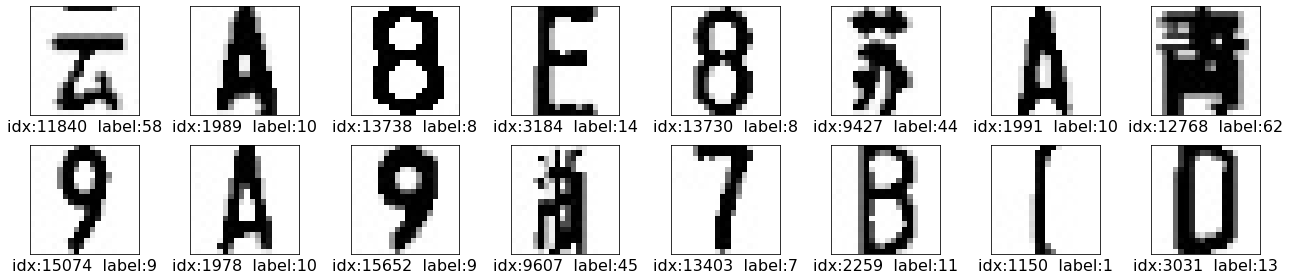

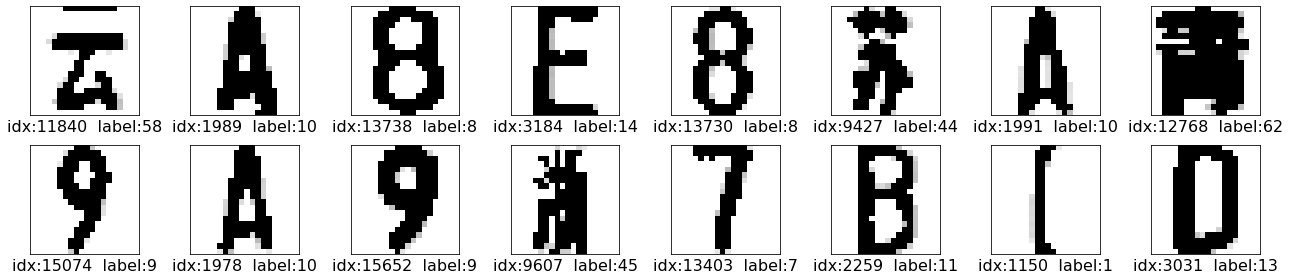

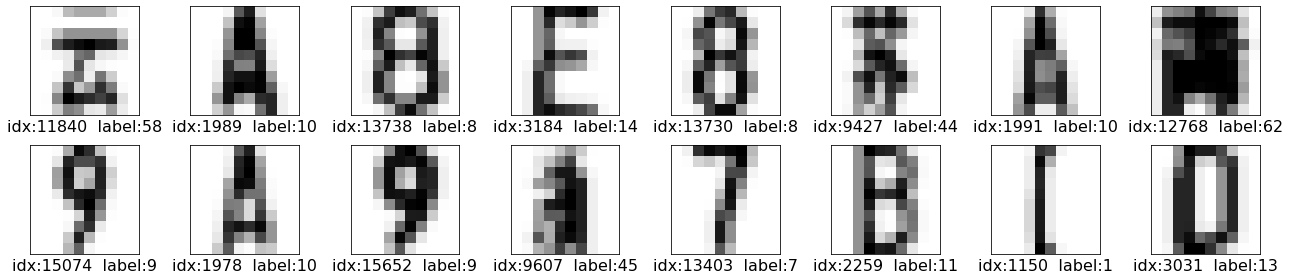

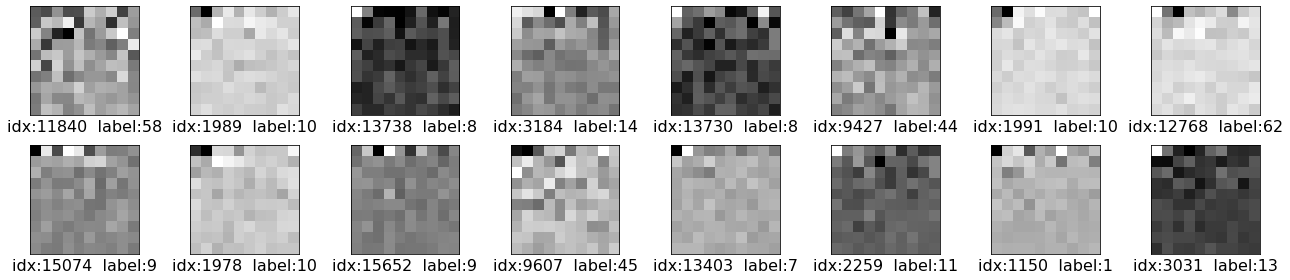

In [156]:
draw_lst = np.random.randint(0, len(raw_X), size=(16))
draw(raw_X, train_y, draw_lst, 20)
draw(train_X, train_y, draw_lst, 20)
draw(X_Nraw, train_y, draw_lst, 10)
draw(X_Praw, train_y, draw_lst, 10)


In [3]:
# 使用sklearn库编写的knn和交叉验证
def knn_sklearn(X, y, ks=[3], method=1):
    best_k, best_score = ks[0], 0
    best_k_w, best_score_w = ks[0], 0
    score, score_w = [], []
    # 不带权重
    for k in tqdm(ks):
        cur_score = 0
        clf = KNeighborsClassifier(
            n_neighbors=k, weights='uniform', p=method)
        cur_score = cross_val_score(
            clf, X, y, cv=3, scoring='accuracy')
        avg_score = cur_score.mean()
        score.append(avg_score)
        if avg_score > best_score:
            best_score = avg_score
            best_k = k
        print("current best score is %.4f   " %
              best_score, "   best k: %d" % best_k)

    # 带距离权重
    for k in tqdm(ks):
        clf_w = KNeighborsClassifier(
            n_neighbors=k, weights='distance', p=method)
        cur_score_w = cross_val_score(
            clf_w, X, y, cv=3, scoring='accuracy')
        avg_score_w = cur_score_w.mean()
        score_w.append(avg_score_w)
        if avg_score_w > best_score_w:
            best_score_w = avg_score_w
            best_k_w = k
        print("current best score(w) is %.4f" %
              best_score_w, "   best k: %d" % best_k_w)

    return score, score_w


## 五、模型调优
KNN分类中共有三类超参数需要选择：
1. K值。K值选取对分类的结果影响至关重要，K值选取的太小，模型太复杂；K值选取的太大，导致分类模糊。本文将通过K折交叉验证(Cross Validation)法评估模型在不同取值下的性能，进而确定具体问题的K值。首先k值通常选奇数，这样就可以避免出现平局，因为K折交叉验证运行速度较慢，所以预先采用3折验证和间隔为4的序列“[1, 5, 9,13,17, 21,25]”分别作为k值，以确定k的大概范围。
2. 距离。距离用于度量两个点之间的远近程度，比较常用的是选用欧式距离，也称L2距离，KNeighborsClassifier方法中还提供了L1曼哈顿距离和Ln明可夫斯基（N）距离，此处仅对L1和L2距离进行了比对。
3. 得分是否带权。表示k近邻点都分类结果的影响，一般的情况下是选取k近邻点中类别数目最多的作为分类结果，即默认k个点的权重相等，但在很多情况下权重并不相等，可能近的点对分类结果影响大时有更好表现。此处对'uniform'（表示所有点的权重相等）和'distance'（表示权重是距离的倒数，意味着k个点中距离近的点对分类结果的影响大于距离远的点）两种方式下准确率进行了比较。

In [166]:
ks = [1, 3, 5, 7]
score_l1, score_l1_w = knn_sklearn(X_Nraw, train_y, ks, 1)
score_l2, score_l2_w = knn_sklearn(X_Nraw, train_y, ks, 2)


 25%|██▌       | 1/4 [00:32<01:37, 32.36s/it]

current best score is 0.9512       best k: 1


 50%|█████     | 2/4 [01:10<01:07, 34.00s/it]

current best score is 0.9512       best k: 1


 75%|███████▌  | 3/4 [01:49<00:35, 35.67s/it]

current best score is 0.9512       best k: 1


  0%|          | 0/4 [00:00<?, ?it/s]

current best score is 0.9512       best k: 1


 25%|██▌       | 1/4 [00:28<01:24, 28.30s/it]

current best score(w) is 0.9512    best k: 1


 50%|█████     | 2/4 [01:02<01:00, 30.17s/it]

current best score(w) is 0.9512    best k: 1


 75%|███████▌  | 3/4 [01:36<00:31, 31.31s/it]

current best score(w) is 0.9512    best k: 1


  0%|          | 0/4 [00:00<?, ?it/s]

current best score(w) is 0.9512    best k: 1


 25%|██▌       | 1/4 [00:28<01:24, 28.01s/it]

current best score is 0.9564       best k: 1


 50%|█████     | 2/4 [01:05<01:01, 30.98s/it]

current best score is 0.9564       best k: 1


 75%|███████▌  | 3/4 [01:40<00:32, 32.04s/it]

current best score is 0.9564       best k: 1


  0%|          | 0/4 [00:00<?, ?it/s]

current best score is 0.9564       best k: 1


 25%|██▌       | 1/4 [00:25<01:15, 25.33s/it]

current best score(w) is 0.9564    best k: 1


 50%|█████     | 2/4 [00:58<00:55, 27.65s/it]

current best score(w) is 0.9566    best k: 3


 75%|███████▌  | 3/4 [01:33<00:29, 29.81s/it]

current best score(w) is 0.9566    best k: 3


100%|██████████| 4/4 [02:10<00:00, 32.70s/it]

current best score(w) is 0.9566    best k: 3


In [167]:
print(score_l1, score_l1_w, score_l2, score_l2_w)


[0.9512348000501442, 0.9432744139400778, 0.9402657640717061, 0.9375078350256989] [0.9512348000501442, 0.9497304751159583, 0.9482888303873637, 0.9463457440140405] [0.9564372571142034, 0.951046759433371, 0.9492917136768209, 0.9472232668923154] [0.9564372571142034, 0.9565626175253854, 0.9549956123856087, 0.954431490535289]


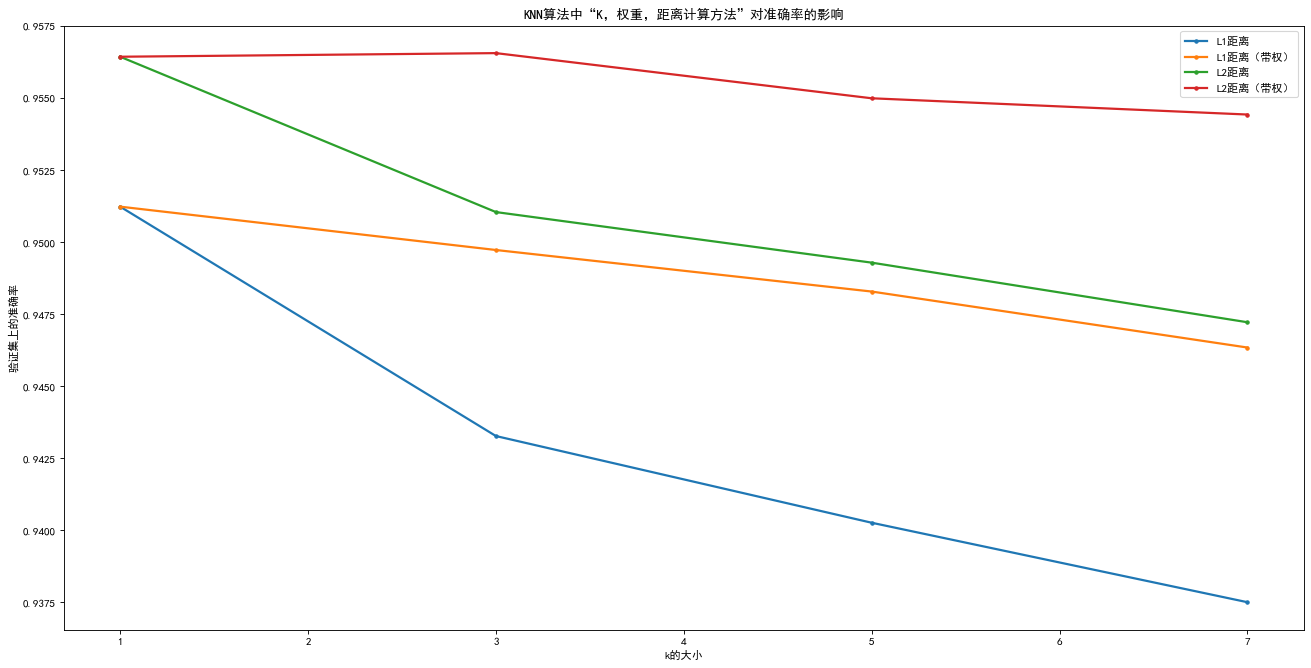

In [168]:
def drawfig(x_axis_data):
    fig1 = plt.figure(num=3, figsize=(20, 10), dpi=80)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    # 三个参数分别为：行数，列数，本子图是所有子图中的第几个，最后一个参数设置错了子图可能发生重叠

    plt.xlabel('k的大小')
    plt.ylabel('验证集上的准确率')
    plt.title("KNN算法中“K，权重，距离计算方法”对准确率的影响")

    plt.plot(x_axis_data, score_l1,
            label="L1距离", linewidth=2,  marker='.')
    plt.plot(x_axis_data, score_l1_w,
            label="L1距离（带权）", linewidth=2,  marker='.')
    plt.plot(x_axis_data, score_l2,
            label="L2距离", linewidth=2,  marker='.')
    plt.plot(x_axis_data, score_l2_w,
            label="L2距离（带权）", linewidth=2,  marker='.')

    plt.legend()
    plt.show()

drawfig(ks)

可以发现，k取1，距离计算使用L2距离，得分计算使用带权计算有着最好的性能。下面在测试集上测试准确率。

In [15]:
clf = KNeighborsClassifier(n_neighbors=1, weights='distance', p=2)
clf.fit(train_X, train_y)
t1 = time.time()
res = clf.score(test_X, test_y)
t2 = time.time()
print('Time:', t2-t1, " Accurancy:", res)


Time: 65.19474601745605  Accurancy: 0.7747052518756699


下面分析训练集大小对结果的影响，发现并非数据集越大效果越好，可能是因为k取1比较容易偏向某个特定实例，随机划分将那些特征不明显的数据集剔除了。

In [16]:
scales = [0.2, 0.4, 0.6, 0.8]
accus = dict()
for scale in scales:
    x1, x2, y1, y2 = train_test_split(train_X, train_y, test_size=scale, random_state=22742)
    clf = KNeighborsClassifier(n_neighbors=1, weights='distance', p=2)
    clf.fit(x1, y1)
    res = clf.score(test_X, test_y)
    print("Scale:",scale , " Accurancy:", res)



Scale: 0.2  Accurancy: 0.75005359056806
Scale: 0.4  Accurancy: 0.7281886387995713
Scale: 0.6  Accurancy: 0.7187566988210075
Scale: 0.8  Accurancy: 0.6844587352625938
